# Binary Classification using Linear Learner to Classify American or English Barleywine

The data is currated from https://www.kaggle.com/datasets/jtrofe/beer-recipes to remove rows with missing values. The dataset was sufficiently large that the resulting file had enough data to see a 92% accuracy rate. The features of this set include Specific gravity of wort before fermentation, Specific gravity of wort after fermentation, alcohol by volume, International Bittering Units and Color. 

In [85]:
# import data science and visualization libraries
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import boto3

Import and split the data

In [93]:
s3 = boto3.client("s3")
# read the csv and extract features and labels
barleywine = pd.read_csv("barleywine.csv", delimiter=",", dtype="float32").values
barleywine_features, barleywine_labels = barleywine[:, :5], barleywine[:, 0]
# shuffle and split into train and test sets
np.random.seed(0)
# split into train and test sets, with 80% of the data used for training and the remaining 20% being split evenly between validation and testing
train_features, test_features, train_labels, test_labels = train_test_split(
    barleywine_features, barleywine_labels, test_size=0.2
)
# further split the test set into validation and test sets
val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size=0.5
)

Check frequency of occurence for each in the dataset

[0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.

,0
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


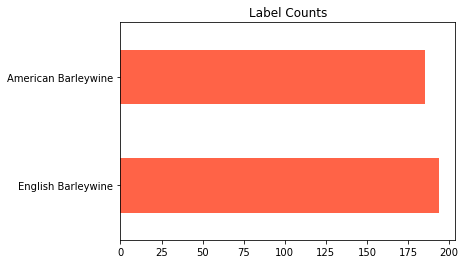

In [94]:
# assign label names and count label frequencies
label_map = {
    1: "American Barleywine",
    0: "English Barleywine"
}
print(train_labels)
label_counts = (
    pd.DataFrame(data=train_labels)[0]
    .map(label_map)
    .value_counts(sort=False)
    .sort_index(ascending=False)
)
label_counts.plot(kind="barh", color="tomato", title="Label Counts")
pd.DataFrame(data=train_labels).head()

Create the estimator

In [95]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# instantiate the LinearLearner estimator object
binary_estimator = sagemaker.LinearLearner(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c4.xlarge",
    predictor_type="binary_classifier",
    num_classes=2,
    feature_dim=6,
    epochs=10,
    mini_batch_size=100,
    use_bias=True,
    binary_classifier_model_selection_criteria="cross_entropy_loss",
)

Use Record_set to create temporary instances of the data in S3 with the apporopriate structure

In [97]:
# wrap data in RecordSet objects
train_records = binary_estimator.record_set(train_features, train_labels, channel="train")
val_records = binary_estimator.record_set(val_features, val_labels, channel="validation")
test_records = binary_estimator.record_set(test_features, test_labels, channel="test")

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-1-177632013314/sagemaker-record-sets/LinearLearner-2022-11-14-17-56-06-189/.amazon.manifest', 'feature_dim': 5, 'num_records': 379, 's3_data_type': 'ManifestFile', 'channel': 'train'})

In [98]:
# start a training job
binary_estimator.fit([train_records, val_records, test_records])

2022-11-14 17:56:14 Starting - Starting the training job...
2022-11-14 17:56:38 Starting - Preparing the instances for trainingProfilerReport-1668448574: InProgress
..................
2022-11-14 17:59:45 Downloading - Downloading input data
2022-11-14 17:59:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/14/2022 17:59:49 INFO 140422464714560] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0

[2022-11-14 17:59:53.492] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 17, "duration": 27, "num_examples": 1, "num_bytes": 3008}
#metrics {"StartTime": 1668448793.5023303, "EndTime": 1668448793.5023627, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 5, "model": 0}, "Metrics": {"validation_binary_classification_cross_entropy_objective": {"sum": 0.6666551143565076, "count": 1, "min": 0.6666551143565076, "max": 0.6666551143565076}}}
#metrics {"StartTime": 1668448793.5024648, "EndTime": 1668448793.502485, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 5, "model": 1}, "Metrics": {"validation_binary_classification_cross_entropy_objective": {"sum": 0.6592508275458153, "count": 1, "min": 0.6592508275458153, "max": 0.6592508275458153}}}
#metrics {"StartTime": 1668448793.502545, "EndTime": 1668448793.5025566, "Dimensions": {"Algorithm": "Linear Learne


2022-11-14 18:00:12 Uploading - Uploading generated training model
2022-11-14 18:00:12 Completed - Training job completed
Training seconds: 52
Billable seconds: 52


In [100]:
# deploy a model hosting endpoint
binary_predictor = binary_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge"
)

-----------!

Test the endpoint with one singular prediction

In [107]:
import random
r = random.randrange(1,50)
print(test_features[r])
binary_predictor.predict(test_features[r])

[ 1.     1.101  1.026  9.86  66.05 ]


[label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.684882640838623
     }
   }
 }]

Define function to determine total model accuracy and visualize data

In [109]:
def evaluate_metrics(predictor, test_features, test_labels):
    """
    Evaluate a model on a test set using the given prediction endpoint. Display classification metrics.
    """
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    prediction_batches = [predictor.predict(test_features[r]) for r in range(len(test_features))]

    # parse protobuf responses to extract predicted labels
    extract_label = lambda x: x.label["predicted_label"].float32_tensor.values
    test_preds = np.concatenate(
        [np.array([extract_label(x) for x in batch]) for batch in prediction_batches]
    )
    test_preds = test_preds.reshape((-1,))

    # calculate accuracy
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]

    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(
            test_preds == target_label, test_labels == target_label
        ).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({"recall": recall_per_class, "class_label": classes})
    recall.sort_values("class_label", ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(
        label_mapper(test_labels),
        label_mapper(test_preds),
        rownames=["Actuals"],
        colnames=["Predictions"],
        normalize="index",
    )

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="YlGnBu").set_title(
        "Confusion Matrix"
    )
    ax = recall.plot(
        kind="barh", x="class_label", y="recall", color="steelblue", title="Recall", legend=False
    )
    ax.set_ylabel("")
    print("Accuracy: {:.3f}".format(accuracy))

Evaluate

Accuracy: 0.917


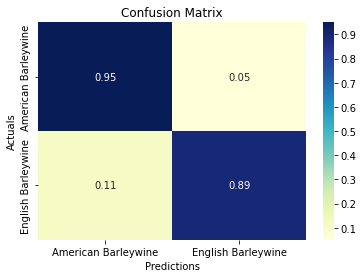

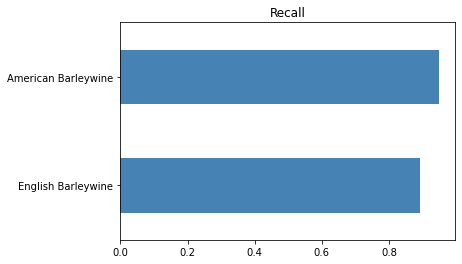

In [110]:
# evaluate metrics of the model trained with default hyperparameters
evaluate_metrics(binary_predictor, test_features, test_labels)

In [111]:
# delete endpoints
binary_predictor.delete_endpoint()
